<a href="https://colab.research.google.com/github/Seonghoon-Yu/Paper_Review_and_Implementation_in_PyTorch/blob/master/NLP/Seq2Seq(2014).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
import spacy
import numpy as np

import random
import math
import time

# 데이터 불러오기

 데이터셋은 PyTorch에서 제공하는 Multi30k dataset을 사용  
 데이터 전처리는 spacy 에서 제공하는 토큰화 모듈을 사용

In [2]:
# 난수 생성
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
# 문장을 토큰화하는 모듈 설치
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [4]:
import de_core_news_sm
import en_core_web_sm

In [5]:
# 문장을 토큰화하는 모델을 불러옵니다.
spacy_en = en_core_web_sm.load()
spacy_de = de_core_news_sm.load()

In [6]:
# tokenizer function 생성
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [7]:
# torchtext의 Field는 데이터를 어떻게 처리할지 조절합니다.
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [8]:
# train, validation, test 데이터를 불러오고, 다운로드 합니다.
# Multi30k dataset을 사용하여, 30,000개의 영어, 독일, 프랑스어 문장을 포함합니다.
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(SRC,TRG))

In [9]:
print(f'Number of training examples: {len(train_data.examples)}')
print(f'Number of validation examples: {len(valid_data.examples)}')
print(f'Number of testing examples: {len(test_data.examples)}')

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [10]:
print(vars(train_data.examples[0]))

{'src': ['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


In [11]:
# min_freq=2는 2번 이상 등장한 토큰을 출력합니다.
# 토큰이 1번만 등장했다면 <unk>로 대체합니다.
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [12]:
print(f'Unique tokens in source (de) vocabulary: {len(SRC.vocab)}')
print(f'Unique tokens in target (en) vocabulary: {len(TRG.vocab)}')

Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


In [13]:
# Iterator 생성
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), batch_size=batch_size, device=device)


# Seq2Seq 구현하기

In [27]:
from PIL import Image

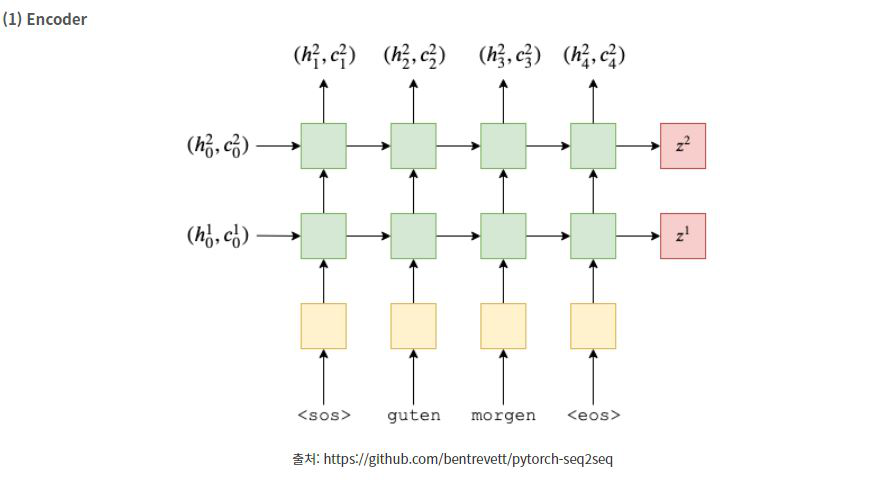

In [28]:
Image.open('../image/Seq2Seq_Encoder.JPG')

 encoder은 LSTM으로 구성되어 있으며, 입력 senquence를 입력받아 encode하여 고정된 크기의 context vector를 생성  
입력 cell과 입력 hidden state는 제로 텐서 

In [14]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        # embedding: 입력값을 emd_dim 벡터로 변경
        self.embedding = nn.Embedding(input_dim, emb_dim)

        # embedding을 입력받아 hid_dim 크기의 hidden state, cell 출력
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # sre: [src_len, batch_size]

        embedded = self.dropout(self.embedding(src))

        # initial hidden state는 zero tensor
        outputs, (hidden, cell) = self.rnn(embedded)

        # output: [src_len, batch_size, hid dim * n directions]
        # hidden: [n layers * n directions, batch_size, hid dim]
        # cell: [n layers * n directions, batch_size, hid dim]

        return hidden, cell

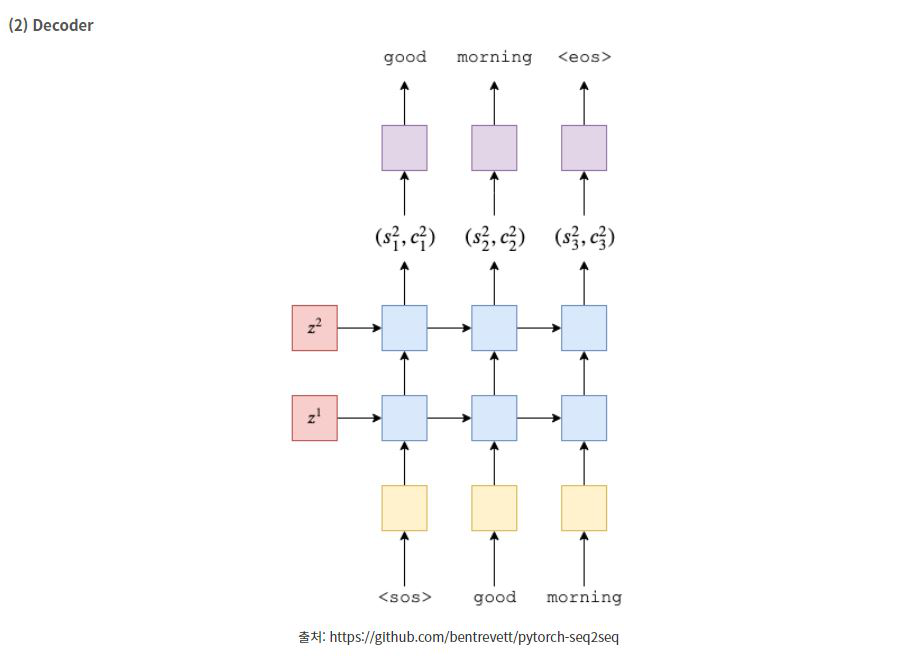

In [29]:
Image.open('../image/Seq2Seq_Decoder.JPG')

Decoder은 encode된 context vector를 입력받아 decode하여 단어를 예측

In [15]:
# decoder
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        # content vector를 입력받아 emb_dim 출력
        self.embedding = nn.Embedding(output_dim, emb_dim)

        # embedding을 입력받아 hid_dim 크기의 hidden state, cell 출력
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)

        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input: [batch_size]
        # hidden: [n layers * n directions, batch_size, hid dim]
        # cell: [n layers * n directions, batch_size, hid dim]

        input = input.unsqueeze(0) # input: [1, batch_size], 첫번째 input은 <SOS>

        embedded = self.dropout(self.embedding(input)) # [1, batch_size, emd dim]

        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output: [seq len, batch_size, hid dim * n directions]
        # hidden: [n layers * n directions, batch size, hid dim]
        # cell: [n layers * n directions, batch size, hid dim]

        prediction = self.fc_out(output.squeeze(0)) # [batch size, output dim]
        
        return prediction, hidden, cell

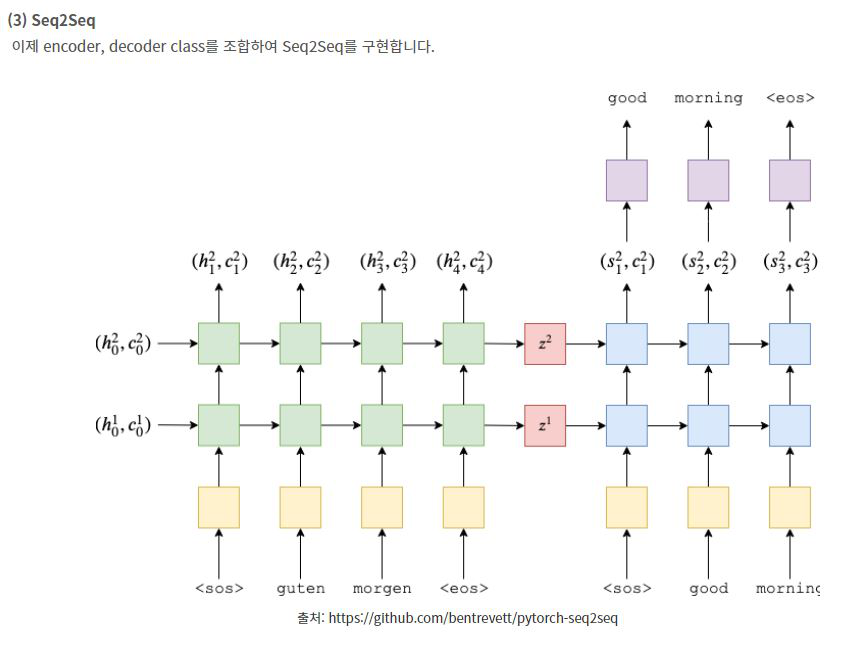

In [30]:
Image.open('../image/Seq2Seq.JPG')

encoder, decoder class를 조합하여 Seq2Seq를 구현

In [16]:
# Seq2Seq
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        # encoder와 decoder의 hid_dim이 일치하지 않는 경우 에러메세지
        assert encoder.hid_dim == decoder.hid_dim, \
            'Hidden dimensions of encoder decoder must be equal'
        # encoder와 decoder의 hid_dim이 일치하지 않는 경우 에러메세지
        assert encoder.n_layers == decoder.n_layers, \
            'Encoder and decoder must have equal number of layers'

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src: [src len, batch size]
        # trg: [trg len, batch size]
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0] # 타겟 토큰 길이 얻기
        trg_vocab_size = self.decoder.output_dim # context vector의 차원

        # decoder의 output을 저장하기 위한 tensor
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # initial hidden state
        hidden, cell = self.encoder(src)

        # 첫 번째 입력값 <sos> 토큰
        input = trg[0,:]

        for t in range(1,trg_len): # <eos> 제외하고 trg_len-1 만큼 반복
            output, hidden, cell = self.decoder(input, hidden, cell)

            # prediction 저장
            outputs[t] = output

            # teacher forcing을 사용할지, 말지 결정
            # teacher forcing은 일정 확률로 다음 lstm cell에 prediction이 아닌, target token을 입력하는 것
            teacher_force = random.random() < teacher_forcing_ratio

            # 가장 높은 확률을 갖은 값 얻기
            top1 = output.argmax(1)

            # teacher forcing의 경우에 다음 lstm에 target token 입력
            input = trg[t] if teacher_force else top1

        return outputs

# 학습하기

In [17]:
# 하이퍼 파라미터 지정
input_dim = len(SRC.vocab)
output_dim = len(TRG.vocab)
enc_emb_dim = 256 # 임베딩 차원
dec_emb_dim = 256
hid_dim = 512 # hidden state 차원
n_layers = 2
enc_dropout = 0.5
dec_dropout = 0.5

In [18]:
# 모델 생성
enc = Encoder(input_dim, enc_emb_dim, hid_dim, n_layers, enc_dropout)
dec = Decoder(output_dim, dec_emb_dim, hid_dim, n_layers, dec_dropout)

model = Seq2Seq(enc, dec, device).to(device)

In [19]:
# 가중치 초기화
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [20]:
# 모델의 학습가능한 파라미터 수 측정
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainableparameters')

The model has 13,898,501 trainableparameters


In [21]:
# optimizer
optimizer = optim.Adam(model.parameters())

# loss function
# pad에 해당하는 index는 무시합니다.
trg_pad_idx = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index=trg_pad_idx)

In [22]:
# 학습을 위한 함수
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        optimizer.zero_grad()

        output = model(src,trg) # [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim) # loss 계산을 위해 1d로 변경
        trg = trg[1:].view(-1) # loss 계산을 위해 1d로 변경

        loss = criterion(output, trg)
        loss.backward()

        # 기울기 clip
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [23]:
# evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            # output: [trg len, batch size, output dim]
            output = model(src, trg, 0) # teacher forcing off
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim) # [(trg len -1) * batch size, output dim]
            trg = trg[1:].view(-1) # [(trg len -1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [24]:
# function to count training time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [25]:
# 학습 시작
num_epochs = 10
clip = 1

best_valid_loss = float('inf')

for epoch in range(num_epochs):
   
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, clip)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 43s
	Train Loss: 5.045 | Train PPL: 155.206
	 Val. Loss: 5.112 |  Val. PPL: 166.082
Epoch: 02 | Time: 0m 40s
	Train Loss: 4.469 | Train PPL:  87.235
	 Val. Loss: 4.787 |  Val. PPL: 119.901
Epoch: 03 | Time: 0m 40s
	Train Loss: 4.193 | Train PPL:  66.193
	 Val. Loss: 4.586 |  Val. PPL:  98.088
Epoch: 04 | Time: 0m 41s
	Train Loss: 4.014 | Train PPL:  55.363
	 Val. Loss: 4.524 |  Val. PPL:  92.206
Epoch: 05 | Time: 0m 41s
	Train Loss: 3.880 | Train PPL:  48.411
	 Val. Loss: 4.508 |  Val. PPL:  90.720
Epoch: 06 | Time: 0m 41s
	Train Loss: 3.752 | Train PPL:  42.591
	 Val. Loss: 4.414 |  Val. PPL:  82.560
Epoch: 07 | Time: 0m 40s
	Train Loss: 3.632 | Train PPL:  37.775
	 Val. Loss: 4.288 |  Val. PPL:  72.816
Epoch: 08 | Time: 0m 39s
	Train Loss: 3.499 | Train PPL:  33.072
	 Val. Loss: 4.164 |  Val. PPL:  64.344
Epoch: 09 | Time: 0m 39s
	Train Loss: 3.370 | Train PPL:  29.067
	 Val. Loss: 4.099 |  Val. PPL:  60.254
Epoch: 10 | Time: 0m 40s
	Train Loss: 3.274 | Train PPL

In [26]:
# best val loss일 때의 가중치를 불러옵니다.
model.load_state_dict(torch.load('tut1-model.pt'))

# test loss를 측정합니다.
test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.003 | Test PPL:  54.739 |
